In [1]:
from matplotlib import colormaps
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict, namedtuple
import math as ma
import seaborn as sns
import importlib

import grouping
importlib.reload(grouping)
from grouping import get_groups, ValuesGroup, print_groups, extract_group

#### Global variables

In [2]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

WORKING_DIR = "/root/tests"
PERF_SCRIPT_RESULTS_FILEPATH = f"{WORKING_DIR}/.perf_mem_results.log"

NODE_1_PHYS_ADDR_START = 0x1840000000

DAHU_NODE_0_CPUID = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62]
DAHU_NODE_1_CPUID = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63]
dahu_cpu_nodes = [1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)]

def in_working_dir(path: str) :
    return os.path.join(WORKING_DIR, path)

In [3]:
CPUID_TO_NODE = {}
matches = re.findall(
    r"NUMA +node\d+ +CPU\(s\): +([\d,]+)", 
    subprocess.run("lscpu", stdout = subprocess.PIPE, universal_newlines = True).stdout
)

NODES_CPUIDS = []

node_id = 0
for cpulist in matches:
    integer_cpulist = [int(cpuid) for cpuid in cpulist.split(',')]
    NODES_CPUIDS.append(integer_cpulist)
    for cpuid in integer_cpulist:
        CPUID_TO_NODE[cpuid] = node_id
    node_id += 1

print(CPUID_TO_NODE)

{0: 0, 2: 0, 4: 0, 6: 0, 8: 0, 10: 0, 12: 0, 14: 0, 16: 0, 18: 0, 20: 0, 22: 0, 24: 0, 26: 0, 28: 0, 30: 0, 32: 0, 34: 0, 36: 0, 38: 0, 40: 0, 42: 0, 44: 0, 46: 0, 48: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 60: 0, 62: 0, 1: 1, 3: 1, 5: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1, 17: 1, 19: 1, 21: 1, 23: 1, 25: 1, 27: 1, 29: 1, 31: 1, 33: 1, 35: 1, 37: 1, 39: 1, 41: 1, 43: 1, 45: 1, 47: 1, 49: 1, 51: 1, 53: 1, 55: 1, 57: 1, 59: 1, 61: 1, 63: 1}


In [25]:
PAGE_SIZE = int(subprocess.run(["getconf", "PAGESIZE"], stdout = subprocess.PIPE, universal_newlines = True).stdout)
print(f"Page size : {PAGE_SIZE}")

matches = re.findall(
    r"start_pfn: +(\d+)\sNode (\d+), +zone +(\w+)", 
    subprocess.run(["cat", "/proc/zoneinfo"], stdout = subprocess.PIPE, universal_newlines = True).stdout
)

# page_size = 4096

NODE_UPPER_BOUNDARIES = []
for m in matches:
    if int(m[1]) > len(NODE_UPPER_BOUNDARIES):
        NODE_UPPER_BOUNDARIES.append(int(m[0]) * PAGE_SIZE)
        
print(f"Node upper boundaries : {NODE_UPPER_BOUNDARIES}")


def get_node_for_physical_address(addr: int):
    boundary_idx = 0
    while boundary_idx < len(NODE_UPPER_BOUNDARIES) and addr >= NODE_UPPER_BOUNDARIES[boundary_idx]:
        boundary_idx += 1
    return boundary_idx

def get_node_for_pfn(pfn: int):
    boundary_idx = 0
    while boundary_idx < len(NODE_UPPER_BOUNDARIES) and pfn * PAGE_SIZE >= NODE_UPPER_BOUNDARIES[boundary_idx]:
        boundary_idx += 1
    return boundary_idx


Page size : 4096
Node upper boundaries : [104152956928]


In [5]:
# TODO Make them adapt to the file
LOAD_L3_MISS_REMOTE_FWD = "mem_load_l3_miss_retired.remote_fwd:P"
LOAD_L3_MISS_REMOTE_HITM = "mem_load_l3_miss_retired.remote_hitm:P"
LOAD_L3_MISS_REMOTE_DRAM = "mem_load_l3_miss_retired.remote_dram:P"

LOAD_L3_MISS_REMOTE_FWD_COLOR = "tab:orange"
LOAD_L3_MISS_REMOTE_HITM_COLOR = "tab:pink"
LOAD_L3_MISS_REMOTE_DRAM_COLOR = "r"

In [6]:
# One color for cpu node : blue or green 

cpu_node_colors = ['tab:blue', 'tab:green', 'tab:brown', 'tab:gray']

def plot_memory_allocation_on_node(df: pd.DataFrame, node: int, x_min = None, x_max = None):
    cpuid_list = sorted(df.cpuid.unique())
    df = df.loc[df['memory_node'] == node]
    
    for cpuid in cpuid_list:
        cpu_df = df.loc[df['cpuid'] == cpuid]
        
        for cpu_node in cpu_df['cpu_node'].unique():
            subset_df = cpu_df.loc[cpu_df['cpu_node'] == cpu_node]
            plt.scatter(subset_df['pfn'], [cpuid] * len(subset_df), c=cpu_node_colors[cpu_node], alpha=0.5, s=40)
            
        # cpu_pfns = sorted(cpu_df['pfn'])
        # if len(cpu_pfns) > 0:
        #     plt.scatter(cpu_pfns, [cpuid] * len(cpu_pfns), c='tab:blue', alpha=0.5, s=40)
        
    plt.gcf().set_size_inches(100, 8)
    plt.yticks(NODES_CPUIDS[node])
    plt.grid(which='both', axis='y')
    if x_min is not None and x_max is not None :
        plt.xlim(left=x_min, right=x_max)
        plt.xticks(np.linspace(x_min, x_max, num=50))
        
    plt.plot()
    

These plots are nice but we want :
- One set of colors to indicate the node of the cpu. Maybe we can get around that by having lines for each cpu in the node. Any cpu not on a line is not from that node
- One set of colors to indicate read vs write ? Does it matter tho ?
- One particular color to indicate that the accessed memory address was allocated by another cpu. Otherwise default color

## Analyzing cpu loads and remote l3 misses

Plot number of l3 remote cache for each CPU. Possibly can be multiplied by the period value

### Filters

In [7]:
def filter_in_bounds(df: pd.DataFrame, bounds: tuple, variable: str):
    if bounds[1] is None:
        return df.loc[df[variable] >= bounds[0]]
    if bounds[0] is None:
        return df.loc[df[variable] < bounds[1]]
    return df.loc[(df[variable] >= bounds[0]) & (df[variable] < bounds[1])]

def filter_local_access(df: pd.DataFrame):
    return df.loc[df['cpu_node'] == df['memory_node']]

def filter_remote_access(df: pd.DataFrame):
    return df.loc[df['cpu_node'] != df['memory_node']]

def filter_loads_stores(df: pd.DataFrame):
    return df.loc[df['event'].str.contains("cpu/")]

def local_access_proportion(df: pd.DataFrame):
    # (sock_df['cpu_node'] == sock_df['memory_node']).astype(int) * sock_df['period']
    return 100 * sum((df['cpu_node'] == df['memory_node']).astype(int) * df['period']) / sum(df['period'])

In [8]:
MemoryEventNames = namedtuple("MemoryEventNames", ["loads", "stores", "load_l3_miss_remote_dram", "load_l3_miss_remote_fwd", "load_l3_miss_remote_hitm"])

# Have to be in the same order as MemoryEventNames
search_patterns = ["cpu/mem-loads", "cpu/mem-stores", "mem_load_l3_miss_retired.remote_dram", "mem_load_l3_miss_retired.remote_fwd", "mem_load_l3_miss_retired.remote_hitm"]

def get_memory_event_names(df: pd.DataFrame) -> MemoryEventNames:
    events_list = df['event'].unique()
    event_names = []
    for sp in search_patterns:
        actual_name = None
        for event in events_list:
            if sp in event:
                actual_name = event
                # event_names.append(event)
                break
        event_names.append(actual_name)
            
    return MemoryEventNames(*event_names)

### Remote vs local stats

In [9]:
def print_locality_stats(df: pd.DataFrame):
    # local_df = filter_local_access(df)
    # remote_df = filter_remote_access(df)

    # TODO Interesting to compare percentage of remote nodes on different pinning modes.
    print(f"Total number of events : {'{:.6e}'.format(len(df))}")
    print(f"Percentage of local loads/stores events : {local_access_proportion(filter_loads_stores(df))}")
    print(f"Percentage of local events : {local_access_proportion(df)}")
    # remote_df = events_df.loc[events_df['cpu_node'] != events_df['memory_node']]
    # remote_df['event'].value_counts()

    fwd_subset = df.loc[df['event'] == LOAD_L3_MISS_REMOTE_FWD]
    hitm_subset = df.loc[df['event'] == LOAD_L3_MISS_REMOTE_HITM]
    dram_subset = df.loc[df['event'] == LOAD_L3_MISS_REMOTE_DRAM]

    print(f"Percentage of {LOAD_L3_MISS_REMOTE_FWD} events where memory is local : {local_access_proportion(fwd_subset)}")
    print(f"Percentage of {LOAD_L3_MISS_REMOTE_HITM} events where memory is local : {local_access_proportion(hitm_subset)}")
    print(f"Percentage of {LOAD_L3_MISS_REMOTE_DRAM} events where memory is local : {local_access_proportion(dram_subset)}")

In [ ]:
# Can we cache a remote dram address ?

print_locality_stats(sock_df)

print_locality_stats(seq_df)

# remote_df.loc[~remote_df['event'].isin(np.array(["cpu/mem-stores/P", "cpu/mem-loads/P"]))]

Kinda wanna have a graph of locality of memory acccess over time

In [10]:
def plot_access_locality_over_time(dfs: List[pd.DataFrame], labels: list[str], min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500):
    if len(dfs) != len(labels):
        raise Exception("label and dfs parameters need to have the same length")
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_locality = []
    agg_count = []
    agg_interval = []
    
    for df in dfs:
        local_percents = []
        bin_count = []
        curr_intervals = []
        for i in range(len(intervals) - 1):
            curr_df = df.loc[(df['time'] >= intervals[i]) & (df['time'] < intervals[i + 1])]
            if len(curr_df) == 0:
                continue
            local_percents.append(local_access_proportion(curr_df))
            bin_count.append(len(curr_df))
            curr_intervals.append(intervals[i])
        agg_locality.append(local_percents)
        agg_count.append(bin_count)
        agg_interval.append(curr_intervals)

    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 7)
    plt.grid(which="both", axis="y")
    plt.ylim(bottom = 0, top = 100)
    for loc, inter, label in zip(agg_locality, agg_interval, labels):
        plt.plot(inter, loc, label=label)
    plt.title(f"Proportion of local / total memory accesses, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

    # plt.minorticks_on()
    # plt.gcf().set_size_inches(15, 7)
    # plt.grid(which="both", axis="y")
    # plt.plot(intervals[:-1], sums)
    # plt.show()
    
            
    

In [ ]:
plot_access_locality_over_time([sock_df, seq_df], ["sockorder", "sequential"], min_t=0.0, max_t=1.5)

In [ ]:
df = sock_df
intervals = [0.0, 0.1]
i = 0
((df['time'] >= intervals[i]) & (df['time'] < intervals[i + 1])).astype(int) * df['period']

In [11]:
def plot_event_over_time(dfs: List[pd.DataFrame], labels: List[str], event: str, min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500, w = 15, h = 7):
    if len(dfs) != len(labels):
        raise Exception("dfs and labels parameters need to have the same length")
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    dfs = [df.loc[df['event'] == event] for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_count = []
    
    for df in dfs:
        counts = []
        for i in range(len(intervals) - 1):
            curr_count = filter_in_bounds(df, (intervals[i], intervals[i + 1]), "time")['period'].sum()
            counts.append(curr_count)
        agg_count.append(counts)

    plt.minorticks_on()
    plt.gcf().set_size_inches(w, h)
    plt.grid(which="both", axis="y")
    plt.grid(which="major", axis="x")
    # plt.ylim(bottom = 0, top = 100)
    for counts, label in zip(agg_count, labels):
        plt.plot(intervals[:-1], counts, label=label)
    plt.xticks(np.linspace(min_t, max_t, int(w * 1.5)), rotation=20, ha='right')
    plt.title(f"Number of {event}, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

In [ ]:
plot_event_over_time([seq_df, sock_df], ["sequential", "sockorder"], LOAD_L3_MISS_REMOTE_DRAM, bins=500, min_t=0.5, max_t=0.7, w=20, h=6)

In [ ]:
plot_event_over_time([seq_df, sock_df], ["sequential", "sockorder"], LOAD_L3_MISS_REMOTE_DRAM, bins=500, min_t=0.6750, max_t=0.6793, w=24, h=8)

In [ ]:
TIME_START = 0.678931
TIME_END = 0.679054

### Event counts per CPU

In [12]:
def plot_event_count_per_cpu(dfs: List[pd.DataFrame], names: List[str], event: str) :
    dfs = [df.loc[df['event'] == event] for df in dfs]
    dfs = [df.groupby('cpuid')['period'].sum().reset_index() for df in dfs]
    
    for df, name in zip(dfs, names):
        df['source'] = name
        
    combined_df = pd.concat(dfs)
        
    plt.figure(figsize=(30, 10))
    sns.barplot(x='cpuid', y='period', hue='source', data=combined_df)

    # Add labels and title
    plt.xlabel('CPU')
    plt.ylabel('Number of events')
    plt.title(f"Count of {event} per CPU")
    plt.show()
    

In [ ]:
for event in seq_df['event'].unique() :
    plot_event_count_per_cpu([seq_df, sock_df], ["sequential", "sockorder"], event)

## Address space

### Vizualization

In [ ]:
def relative_to_bounds(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return int((bounds[0] / relative_range) * range), int((bounds[1] / relative_range) * range)

def bounds_to_relative(df: pd.DataFrame, bounds: Tuple[int, int], variable: str, relative_range = 100):
    min_range = df[variable].min()
    max_range = df[variable].max()
    range = max_range - min_range
    return ((bounds[0] - min_range) * relative_range) / range, ((bounds[1] - min_range) * relative_range) / range

## Visualization of memory

TODO : Do the same thing but over time

In [ ]:
def plot_physical_memory_map(df: pd.DataFrame, outer_clusters_size = 1e10, inner_clusters_size = 1e8):
    outer_groups = get_groups(df['phys'].to_numpy(), outer_clusters_size, 1000)
    print_groups(outer_groups)
        
    fig, axs = plt.subplots(1, len(outer_groups), figsize=(40, 40))

    for i, og in enumerate(outer_groups):
        inner_df = extract_group(df, og, variable="phys").sort_values("phys").reset_index(drop=True)
        sorted_local_physaddr = inner_df["phys"].to_numpy()
        inner_groups = get_groups(sorted_local_physaddr, inner_clusters_size, 1000)
        # print_groups(inner_groups)
        
        axs[i].plot(range(len(sorted_local_physaddr)), sorted_local_physaddr)
        for cluster in inner_groups :
            axs[i].axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
            axs[i].axhline(y=cluster[1], color='purple', linestyle='--', linewidth=0.2)
            
        for nub in NODE_UPPER_BOUNDARIES:
            if nub >= og[0] and nub < og[1]:
                axs[i].axhline(y=nub, color='r', linestyle='--', linewidth=0.8)
            
        relative_bounds = bounds_to_relative(df, og, 'phys')
        axs[i].set_title(f"{'{:.2f}'.format(relative_bounds[0])} - {'{:.2f}'.format(relative_bounds[1])} % of entire address space")
        
        l3_miss_dram_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
        l3_miss_fwd_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
        l3_miss_hitm_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
        
        if len(l3_miss_dram_df) > 0:
            axs[i].scatter(l3_miss_dram_df.index, l3_miss_dram_df['phys'], label="l3 miss remote dram", color='r', s=15, alpha=0.5, zorder=3)
        if len(l3_miss_fwd_df) > 0:
            axs[i].scatter(l3_miss_fwd_df.index, l3_miss_fwd_df['phys'], label="l3 miss remote fwd", color='tab:orange', s=10, alpha=0.5, zorder=4)
        if len(l3_miss_hitm_df) > 0:
            axs[i].scatter(l3_miss_hitm_df.index, l3_miss_hitm_df['phys'], label="l3 miss remote hitm", color='tab:pink', s=10, alpha=0.5, zorder=5)
        
        # for event in inner_df['event'].unique() :
        #     if "l3_miss_retired.remote_dram" not in event:
        #         continue
        #     # plot_event_count_per_cpu(events_df_sorted_phys, event)
        #     filtered_df = events_df_sorted_phys.loc[events_df_sorted_phys['event'] == event]
        #     plt.scatter(filtered_df.index, filtered_df['phys'], label=event, c='r', s=2, alpha=0.8, zorder=10)

        # # plt.scatter(l3_remote_df.index, l3_remote_df['phys'], s=2, color='r', alpha=0.1)

        # plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
        # plt.gcf().set_size_inches(10, 15)
        # plt.title("Physical addresses ordered")
        # plt.legend(title='Cache Result', loc="best")
    plt.show()

In [ ]:
plot_physical_memory_map(sock_df)

### Clustering

In [ ]:
def get_stats_for_event_in_cluster(df: pd.DataFrame, cluster: tuple, event: str):
    bounded_subset = filter_in_bounds(df, 'phys', cluster)
    event_subset = bounded_subset.loc[bounded_subset['event'] == event]
    if len(event_subset) == 0 :
        return None
    cpuids = event_subset['cpuid'].unique()
    count_per_cpu: List[Tuple[int, int]] = []
    for cid in cpuids:
        number = (event_subset['cpuid'] == cid).sum()
        count_per_cpu.append((number, cid))
    # display(event_subset)
    return (cluster[0], cluster[1], len(event_subset), sorted(count_per_cpu, reverse=True))

def print_cluster_info(name, cluster: Tuple[int, int, int]):
    print(f"Cluster {name} -- bounds : {cluster[0], cluster[1]}, size : {'{:.3e}'.format(cluster[1] - cluster[0])}, total events : {cluster[2]}")

def get_clusters_that_contain_event(df: pd.DataFrame, clusters: list, event: str):
    # clusters could be converted to named tuple
    res = []
    for cluster in clusters:
        bounded_subset = filter_in_bounds(df, 'phys', cluster)
        event_subset = bounded_subset.loc[bounded_subset['event'] == event]
        if len(event_subset) > 0 :
            cpuids = event_subset['cpuid'].unique()
            count_per_cpu: List[Tuple[int, int]] = []
            for cid in cpuids:
                number = (event_subset['cpuid'] == cid).sum()
                count_per_cpu.append((number, cid))
            # display(event_subset)
            res.append((cluster[0], cluster[1], len(event_subset), sorted(count_per_cpu, reverse=True)))
    return sorted(res, reverse=True, key=lambda x: x[2])


def merge_clusters(clusters: list):
    starts = [c[0] for c in clusters]
    ends = [c[1] for c in clusters]
    return (min(starts), max(ends))

In [ ]:
clusters_for_event = get_clusters_that_contain_event(events_df, phys_clusters, "mem_load_l3_miss_retired.remote_dram:P")
for i, cluster in enumerate(clusters_for_event) :
    print(f"Cluster {i} -- bounds : {cluster[0], cluster[1]}, size : {'{:.3e}'.format(cluster[1] - cluster[0])}, total events : {cluster[2]}, list of (n events on cpu, cpu) : {cluster[3]}")
    if i > 20:
        break

In [ ]:
def plotmem(df: pd.DataFrame, column: str = 'phys', cpuid = [], exclude_cpuid = [], min_t = None, max_t = None, w = 60, h = 30, dot_size = 10) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = cpu_df
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, (min_t, max_t), 'time')
        
    me_names = get_memory_event_names(bounded_df)
    loads_df = bounded_df.loc[bounded_df['event'] == me_names.loads]
    stores_df = bounded_df.loc[bounded_df['event'] == me_names.stores]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df[column], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df[column], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[column], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[column], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[column], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[column], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
    plt.gcf().set_size_inches(w, h)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title(f"Scatter plot of {column} addresses over time")
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [ ]:
# 'cpu/mem-loads/P' 'cpu/mem-stores/P'
#  'mem_load_l3_miss_retired.local_dram:P'
#  'mem_load_l3_miss_retired.remote_dram:P'
#  'mem_load_l3_miss_retired.remote_hitm:P'
#  'mem_load_l3_miss_retired.remote_fwd:P']

def plot_phys(df: pd.DataFrame, phys_bounds: tuple, cpuid = [], exclude_cpuid = [], min_t = None, max_t = None, w = 60, h = 30, dot_size = 3) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = filter_in_bounds(cpu_df, 'phys', phys_bounds)
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, 'time', (min_t, max_t))
    
    loads_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-loads/P"]
    stores_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-stores/P"]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
    
    plt.gcf().set_size_inches(w, h)
    plt.scatter(loads_df['time'], loads_df['phys'], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    plt.scatter(stores_df['time'], stores_df['phys'], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df['phys'], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df['phys'], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df['phys'], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df['phys'], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
        # break

    # fig = plt.gcf()
    # if width is None :
    #     width = 28
    # if height is None :
    #     height = 12
    # plt.gcf().set_size_inches(120, 60)
    # plt.gcf().set_size_inches(60, 30)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Phys')
    plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [ ]:
def relative_to_bounds(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return int((bounds[0] / 1000) * range), int((bounds[1] / 1000) * range)

def bounds_to_relative(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return (bounds[0] * 1000) / range, (bounds[1] * 1000) / range

In [ ]:
print(bounds_to_relative(clusters_for_event[8]))
new_bounds = relative_to_bounds((48.3422, 50.4363))
new_bounds

In [ ]:
plot_phys(events_df, clusters_for_event[0], min_t=0.7, max_t=0.8, w = 30, h = 15, dot_size=30)

In [ ]:
filtered_df = filter_in_bounds(events_df, "phys", clusters_for_event[0])
filtered_df = filtered_df.loc[(filtered_df['cpuid'] == 4) & (filtered_df['event'] == "mem_load_l3_miss_retired.remote_dram:P")]

filtered_clusters = get_cluster_bounds(filtered_df['phys'].to_numpy(), 1e6, 10)
for i, cluster in enumerate(filtered_clusters) :
    print_cluster_info(i, cluster)

## Fixed page investigation

In here we want to get the pfn for an address, and then filter all the access to that particular pfn.
x axis : time
y axis : cpu

In [ ]:
MemoryEventNames = namedtuple("MemoryEventNames", ["loads", "stores", "load_l3_miss_remote_dram", "load_l3_miss_remote_fwd", "load_l3_miss_remote_hitm"])

# Have to be in the same order as MemoryEventNames
search_patterns = ["cpu/mem-loads", "cpu/mem-stores", "mem_load_l3_miss_retired.remote_dram", "mem_load_l3_miss_retired.remote_fwd", "mem_load_l3_miss_retired.remote_hitm"]

def get_memory_event_names(df: pd.DataFrame) -> MemoryEventNames:
    events_list = df['event'].unique()
    event_names = []
    for sp in search_patterns:
        actual_name = None
        for event in events_list:
            if sp in event:
                actual_name = event
                # event_names.append(event)
                break
        event_names.append(actual_name)
            
    return MemoryEventNames(*event_names)

In [ ]:
events_list = seq_df['event'].unique()
search_patterns = ["cpu/mem-loads", "cpu/mem-stores", "mem_load_l3_miss_retired.remote_dram", "mem_load_l3_miss_retired.remote_fwd", "mem_load_l3_miss_retired.remote_hitm"]
event_names = []
for sp in search_patterns:
    for event in events_list:
        if sp in event:
            event_names.append(event)
event_names

In [ ]:
# Number of pages to consider before and after
def plot_page_accesses(df: pd.DataFrame, address: int, radius = 0, min_t = None, max_t = None, w = 24, dot_size = 15):
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        df = filter_in_bounds(df, (min_t, max_t), 'time')
    # cpuids = sorted(df.cpuid.unique())
    
    # address_len = address.bit_length()
    # print(address_len)
    mask = ~(PAGE_SIZE - 1)
    pfn = address & mask
    lower_bound = pfn - radius * PAGE_SIZE
    upper_bound = pfn + (radius + 1) * PAGE_SIZE - 1
    
    print(f"lower bound : {lower_bound}, upper bound : {upper_bound}, size : {upper_bound - lower_bound + 1}")
    
    pages_df = filter_in_bounds(df, (lower_bound, upper_bound), "phys")
    cpuids = pages_df.cpuid.unique()
    me_names = get_memory_event_names(pages_df)
    loads_df = pages_df.loc[pages_df['event'] == me_names.loads]
    stores_df = pages_df.loc[pages_df['event'] == me_names.stores]
    l3_miss_dram_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df.cpuid, label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df.cpuid, label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df.cpuid, label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df.cpuid, label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df.cpuid, label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    plt.gcf().set_size_inches(w, len(cpuids))
    plt.ylim(bottom = min(cpuids) - 1, top = max(cpuids) + 1)
    plt.grid(which="major", axis="y")
    plt.yticks(list(range(min(cpuids), max(cpuids) + 2)))
    plt.show()
    
    return lower_bound, upper_bound, list(cpuids)
    
    # return page_df
    

In [ ]:
# Type should be either phys or virt
def plot_virt_page_access(df: pd.DataFrame, address: int, addr_type: str, radius = 0, min_t = None, max_t = None, w = 24, dot_size = 15):
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        df = filter_in_bounds(df, (min_t, max_t), 'time')
        
    mask = ~(PAGE_SIZE - 1)
    pfn = address & mask
    lower_bound = pfn - radius * PAGE_SIZE
    upper_bound = pfn + (radius + 1) * PAGE_SIZE - 1
    
    print(f"Address type : {addr_type}, lower bound : {lower_bound}, upper bound : {upper_bound}, size : {upper_bound - lower_bound + 1}")
    
    pages_df = filter_in_bounds(df, (lower_bound, upper_bound), addr_type)
    cpuids = list(pages_df.cpuid.unique())
    me_names = get_memory_event_names(pages_df)
    loads_df = pages_df.loc[pages_df['event'] == me_names.loads]
    stores_df = pages_df.loc[pages_df['event'] == me_names.stores]
    l3_miss_dram_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df.cpuid, label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df.cpuid, label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df.cpuid, label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df.cpuid, label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df.cpuid, label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    plt.gcf().set_size_inches(w, len(cpuids))
    plt.ylim(bottom = min(cpuids) - 1, top = max(cpuids) + 1)
    plt.grid(which="major", axis="y")
    plt.yticks(list(range(min(cpuids), max(cpuids) + 2)))
    plt.show()
    
    return lower_bound, upper_bound, cpuids

In [ ]:
plot_virt_page_access(seq_df, 140719628192960, "virt", radius=600, max_t=0.9)

In [ ]:
plotmem(filter_in_bounds(seq_df, (140719625732096, 140719630651391), "virt"), column="virt", cpuid=[36, 37, 35], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)

In [ ]:
# Maybe we can go even further and cluster the addresses within the nodes
filtered_virt_df = filter_in_bounds(seq_df, (140719625732096, 140719630651391), "virt")
node_0_df = filter_in_bounds(filtered_virt_df, (None, NODE_UPPER_BOUNDARIES[0]), "phys")
node_1_df = filter_in_bounds(filtered_virt_df, (NODE_UPPER_BOUNDARIES[0], None), "phys")
plotmem(node_0_df, column="phys", cpuid=[35, 36], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)
plotmem(node_0_df, column="phys", cpuid=[37], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)
plotmem(node_1_df, column="phys", cpuid=[36, 37, 35], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)

In [ ]:
filtered_virt_df = filter_in_bounds(seq_df, (140719625732096, 140719630651391), "virt")
node_0_df = filter_in_bounds(filtered_virt_df, (None, NODE_UPPER_BOUNDARIES[0]), "phys")
node_1_df = filter_in_bounds(filtered_virt_df, (NODE_UPPER_BOUNDARIES[0], None), "phys")
plotmem(node_0_df, column="phys", cpuid=[35, 36], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)
plotmem(node_0_df, column="phys", cpuid=[37], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)
plotmem(node_1_df, column="phys", cpuid=[36, 37, 35], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)

for i in range():
    lower_bound = None
    upper_bound = nup
    node_df = filter_in_bounds(filtered_virt_df, (lower_bound, upper_bound), "phys")

In [ ]:
def multiplot_page(df: pd.DataFrame, address: int, radius = 0, min_t = None, max_t = None, w = 24, dot_size = 15):
    lower_bound, upper_bound, cpuids = plot_page_accesses(df, address, radius, min_t, max_t)
    plotmem(filter_in_bounds(df, (lower_bound, upper_bound), "phys"), column="phys", cpuid=cpuids, min_t=min_t, max_t=max_t, w = 30, h = 15, dot_size=40)
    plotmem(filter_in_bounds(df, (lower_bound, upper_bound), "phys"), column="virt", cpuid=cpuids, min_t=min_t, max_t=max_t, w = 30, h = 15, dot_size=40)

In [ ]:
multiplot_page(seq_df, 107165748416, radius=600, max_t=0.9)

# Studying memory allocation and access

In [13]:
def read_allocations_perf_record(file_path, extract_data_again = False):
    temp_file_path = os.path.join(os.path.dirname(file_path), ".perf.log")
    
    if not os.path.isfile(temp_file_path) or extract_data_again: 
        command_str = f"perf script -i {file_path} -L -c cg.C.x -F +period > {temp_file_path}"
        print(f"Executing extraction command : {command_str}")
        result = subprocess.run(
            command_str,
            shell=True,
            stdout = subprocess.PIPE,
            universal_newlines = True
        )
        print(f"Output : {result.stdout}")
    
    # Page is same as pfn
    # pid, cpu, timestamp, period, page, pfn, order
    page_alloc_regex = re.compile(r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +kmem:mm_page_alloc: +page=0x([0-9a-f]+) +pfn=0x([0-9a-f]+) +order=(\d+)")
    memory_access_regex = re.compile(r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(cpu\/[^\/\,]+)\S*\/\w?: +([0-9a-f]+).* ([0-9a-f]+)$")
    
    pids = []
    cpuids = []
    times = []
    pfns = []
    orders = []
    
    access_pids = []
    access_cpuids = []
    access_times = []
    access_periods = []
    access_events = []
    access_virts = []
    access_phys = []
    with open(temp_file_path, 'r') as f:
        for line in f:
            matched = page_alloc_regex.match(line)
            if matched:
                pids.append(int(matched[1]))
                cpuids.append(int(matched[2]))
                times.append(float(matched[3]))
                pfns.append(int(matched[6], base=16))
                orders.append(int(matched[7]))
                continue
            
            matched = memory_access_regex.match(line)
            if matched:
                access_pids.append(int(matched[1]))
                access_cpuids.append(int(matched[2]))
                access_times.append(float(matched[3]))
                access_periods.append(int(matched[4]))
                access_events.append(matched[5])
                access_virts.append(int(matched[6], base=16))
                access_phys.append(int(matched[7], base=16))
                
    alloc_df = pd.DataFrame({
        'pid': pids,
        'cpuid': cpuids,
        'time': times,
        'pfn': pfns,
        'order': orders
    })
    alloc_df['cpu_node'] = alloc_df['cpuid'].map(CPUID_TO_NODE)
    alloc_df['memory_node'] = alloc_df['pfn'].map(lambda x: get_node_for_physical_address(x * PAGE_SIZE))
    
    access_df = pd.DataFrame({
        'pid': access_pids,
        'cpuid': access_cpuids,
        'time': access_times,
        'period': access_periods,
        'event': access_events,
        'virt': access_virts,
        'phys': access_phys
    })
    access_df['pfn'] = access_df['phys'] / PAGE_SIZE
    access_df['pfn'] = access_df['pfn'].astype(np.int64)
    access_df['cpu_node'] = access_df['cpuid'].map(CPUID_TO_NODE)
    access_df['memory_node'] = access_df['phys'].map(get_node_for_physical_address)
    
    return alloc_df, access_df

In [14]:
alloc_df, access_df = read_allocations_perf_record("/root/tests/perf.data")

In [18]:
pfn_groups = get_groups(access_df['pfn'], 1e4, 0)
pfn_groups = sorted(pfn_groups, key = lambda x: x.size, reverse = True)
print_groups(pfn_groups)


Group 0 -- bounds : (26776068, 26785872), width : 9.804e+03, size : 11927
Group 1 -- bounds : (26804740, 26813434), width : 8.694e+03, size : 10859
Group 2 -- bounds : (4142593, 4148200), width : 5.607e+03, size : 10025
Group 3 -- bounds : (26721792, 26731790), width : 9.998e+03, size : 9931
Group 4 -- bounds : (26685952, 26693619), width : 7.667e+03, size : 8840
Group 5 -- bounds : (1480032, 1486847), width : 6.815e+03, size : 7380
Group 6 -- bounds : (26654720, 26662909), width : 8.189e+03, size : 7018
Group 7 -- bounds : (2616253, 2620415), width : 4.162e+03, size : 6924
Group 8 -- bounds : (3776673, 3783678), width : 7.005e+03, size : 6577
Group 9 -- bounds : (3939358, 3949344), width : 9.986e+03, size : 5873
Group 10 -- bounds : (25565979, 25574226), width : 8.247e+03, size : 5735
Group 11 -- bounds : (0, 0), width : 0.000e+00, size : 5719
Group 12 -- bounds : (1424461, 1434271), width : 9.810e+03, size : 5447
Group 13 -- bounds : (2808321, 2814974), width : 6.653e+03, size : 5222

TypeError: 'NoneType' object is not subscriptable

In [15]:
cpu_node_colors = ['tab:blue', 'tab:green', 'tab:brown', 'tab:gray']

def plot_memory_allocation_and_access_on_node(alloc_df: pd.DataFrame, access_df: pd.DataFrame, node: int, x_min: Optional[float] = None, x_max: Optional[float] = None):
    alloc_df = alloc_df.loc[alloc_df['memory_node'] == node]
    access_df = access_df.loc[access_df['memory_node'] == node]
    
    plt.scatter(alloc_df['pfn'], alloc_df['cpuid'], c="tab:blue", alpha=0.5, s=40)
    
    alloc_addr_to_cpu = {int(row['pfn']): int(row['cpuid']) for idx, row in alloc_df.iterrows()}
    access_df['allocator_cpuid'] = access_df['pfn'].map(alloc_addr_to_cpu).fillna(-1).astype(int)
    selector = (access_df['allocator_cpuid'] != -1) & (access_df['allocator_cpuid'] != access_df['cpuid'])
    foreign_access_df = access_df.loc[selector]
    local_access_df = access_df.loc[~selector]
    # print(foreign_access_df['allocator_cpuid'].value_counts())
    # display(foreign_access_df.loc[foreign_access_df['allocator_cpuid'] != 0])
    
    plt.scatter(local_access_df['pfn'], local_access_df['cpuid'], c="tab:green", alpha=0.5, s=20)
    plt.scatter(foreign_access_df['pfn'], foreign_access_df['cpuid'], c="tab:red", alpha=0.5, s=20)
    
    # subset_df = access_df.dropna()
    # subset_df['allocator_cpuid'] = subset_df['allocator_cpuid'].astype(int)
    # foreign_df = subset_df.loc[subset_df['allocator_cpuid'] != subset_df['cpuid']]
    
    
    # cpuid_list = sorted(df.cpuid.unique())
    # df = df.loc[df['memory_node'] == node]
    
    # for cpuid in cpuid_list:
    #     cpu_df = df.loc[df['cpuid'] == cpuid]
        
    #     for cpu_node in cpu_df['cpu_node'].unique():
    #         subset_df = cpu_df.loc[cpu_df['cpu_node'] == cpu_node]
    #         plt.scatter(subset_df['pfn'], [cpuid] * len(subset_df), c=cpu_node_colors[cpu_node], alpha=0.5, s=40)
            
    #     # cpu_pfns = sorted(cpu_df['pfn'])
    #     # if len(cpu_pfns) > 0:
    #     #     plt.scatter(cpu_pfns, [cpuid] * len(cpu_pfns), c='tab:blue', alpha=0.5, s=40)
        
    width = 100
    plt.gcf().set_size_inches(width, 8)
    plt.yticks(NODES_CPUIDS[node])
    plt.grid(which='both', axis='y')
    if x_min is not None and x_max is not None :
        plt.xlim(left=x_min, right=x_max)
        plt.xticks(np.linspace(x_min, x_max, num=width) , rotation=20, ha='right')
        
    plt.plot()

In [26]:
get_node_for_pfn(pfn_groups[0].lower_bound)

1

In [28]:
alloc_df.sort_values('order', ascending=False)

,pid,cpuid,time,pfn,order,cpu_node,memory_node
1835,5178,41,2143.284051,26731520,9,1,1
1832,5164,27,2143.283616,26015232,9,1,1
1827,5181,44,2143.283014,3774464,9,0,0
1822,5195,58,2143.282834,3585536,9,0,0
665,5169,32,2143.200200,3202560,9,0,0
...,...,...,...,...,...,...,...
1566,5151,14,2143.277358,1155830,0,0,0
1567,5170,33,2143.277363,25530940,0,1,1
1568,5139,2,2143.277388,2386109,0,0,0
1571,5160,23,2143.277406,25524698,0,1,1


In [22]:
pfn_groups[0]
filter_in_bounds(access_df, pfn_groups[0], 'pfn')

filter_in_bounds(alloc_df, pfn_groups[0], 'pfn')

,pid,cpuid,time,pfn,order,cpu_node,memory_node
2331,5164,27,2143.621800,26785280,9,1,1
2356,5144,7,2143.621818,26784256,9,1,1
2452,5184,47,2143.624737,26783744,9,1,1
2453,5196,59,2143.624737,26784768,9,1,1
2462,5152,15,2143.624836,26783232,9,1,1
2480,5166,29,2143.624993,26782208,9,1,1
2481,5186,49,2143.624995,26785792,9,1,1
2491,5148,11,2143.625039,26781184,9,1,1
2501,5200,63,2143.625069,26780160,9,1,1
2534,5176,39,2143.627340,26780672,9,1,1


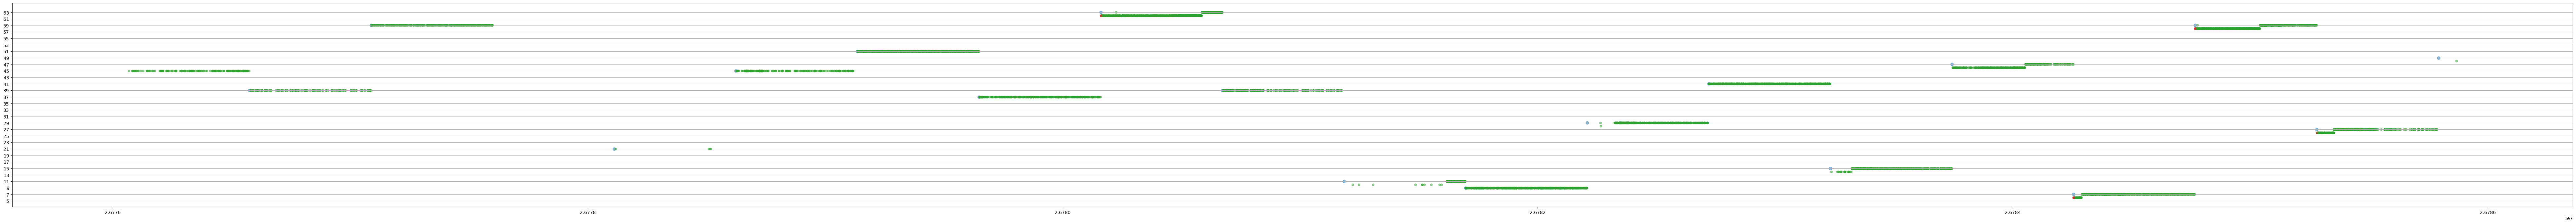

In [27]:
group_id = 0
plot_memory_allocation_and_access_on_node(filter_in_bounds(alloc_df, pfn_groups[group_id], 'pfn'), filter_in_bounds(access_df, pfn_groups[group_id], 'pfn'), get_node_for_pfn(pfn_groups[0].lower_bound))